In [1]:
import numpy as np
import pickle
import sys
from numpy.linalg import norm
from matplotlib import pyplot as plt


def print_log(s):
    sys.stdout.write(s + "\n")
    sys.stdout.flush()


def parse_data(row):
    '''
    Parse each pandas row into a tuple of (station_name, feature_vec),
    where feature_vec is the concatenation of the projection vectors
    of TAVG, TRANGE, and SNWD.
    '''
    return (row[0],
            np.concatenate([row[1], row[2], row[3]]))


def compute_entropy(d):
    '''
    Compute the entropy given the frequency vector `d`
    '''
    d = np.array(d)
    d = 1.0 * d / d.sum()
    return -np.sum(d * np.log2(d))


def choice(p):
    '''
    Generates a random sample from [0, len(p)),
    where p[i] is the probability associated with i. 
    '''
    random = np.random.random()
    r = 0.0
    for idx in range(len(p)):
        r = r + p[idx]
        if r > random:
            return idx
    assert(False)


def kmeans_init(rdd, K, RUNS, seed):
    '''
    Select `RUNS` sets of initial points for `K`-means++
    '''
    # the `centers` variable is what we want to return
    n_data = rdd.count()
    shape = rdd.take(1)[0][1].shape[0]
    centers = np.zeros((RUNS, K, shape))

    def update_dist(vec, dist, k):
        new_dist = norm(vec - centers[:, k], axis=1)**2
        return np.min([dist, new_dist], axis=0)


    # The second element `dist` in the tuple below is the closest distance from
    # each data point to the selected points in the initial set, where `dist[i]`
    # is the closest distance to the points in the i-th initial set.
    data = rdd.map(lambda p: (p, [np.inf] * RUNS)) \
              .cache()
    local_data = rdd.map(lambda (name, vec): vec).collect()
    
    # Randomly select the first data point for every run of k-means++,
    # i.e. randomly select `RUNS` points and add it to the `centers` variable
    sample = [local_data[k] for k in np.random.randint(0, len(local_data), RUNS)]
    centers[:, 0] = sample

    for idx in range(K - 1):
        pre_update = data
        # Update the distance of each data point to the nearest centroid
        data = data.map(lambda ((name, vec), dist):
                            ((name, vec),
                             update_dist(vec, dist, idx))) \
                   .cache()
        # Sample a new data point for each centroid set
        dist = data.map(lambda p: p[1]) \
                   .collect()
        dist = np.array(dist)
        dist = 1.0 * dist / np.sum(dist, axis=0)
        sample = [local_data[choice(dist[:, j])] for j in range(RUNS)]
        centers[:, idx + 1] = sample
        pre_update.unpersist()

    return centers


def get_cost(rdd, centers):
    '''
    Return the indices the nearest centroids of `p`.
    `centers` contains sets of centroids, where `centers[i]` is
    the i-th set of centroids.
    '''
    def _get_cost(p, centers):
        best = [0] * len(centers)
        closest = [np.inf] * len(centers)
        for idx in range(len(centers)):
            for j in range(len(centers[0])):
                temp_dist = norm(p - centers[idx][j])
                if temp_dist < closest[idx]:
                    closest[idx] = temp_dist
                    best[idx] = j
        return np.array(closest)**2
    
    cost = rdd.map(lambda (name, v): _get_cost(v, centroids)).collect()
    return np.array(cost).sum(axis=0)


def get_closest(p, centers):
    best = [0] * len(centers)
    closest = [np.inf] * len(centers)
    for idx in range(len(centers)):
        for j in range(len(centers[0])):
            temp_dist = norm(p - centers[idx][j])
            if temp_dist < closest[idx]:
                closest[idx] = temp_dist
                best[idx] = j
    return best


def kmeans(rdd, K, RUNS, converge_dist, seed):
    '''
    Run K-means++ algorithm on `rdd`, where `RUNS` is the number of
    initial sets to use.
    '''
    k_points = kmeans_init(rdd, K, RUNS, seed)
    print_log("Initialized.")
    temp_dist = 1.0

    iters = 0
    st = time.time()
    while temp_dist > converge_dist:
        # map each data point to its nearest centroid
        closest = rdd.flatMap(
            lambda (name, vec): [((idx, j), (vec, 1))
                                 for idx, j in enumerate(get_closest(vec, k_points))])
        # average all data points that are assigned to the same centroid
        stats = closest.reduceByKey(
            lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
        new_points = stats.mapValues(
            lambda (p, c): 1.0 * p / c).collectAsMap()

        # compute how far the centroids are moved
        temp_dist = np.max([
                np.sum([norm(k_points[idx][j] - new_points[(idx, j)]) for j in range(K)])
                    for idx in range(RUNS)])
        iters = iters + 1
        if iters % 5 == 0:
            print_log("Iteration %d max shift: %.2f (time: %.2f)" %
                      (iters, temp_dist, time.time() - st))
            st = time.time()

        # update centroids
        for ((idx, j), p) in new_points.items():
            k_points[idx][j] = p

    return k_points

In [2]:
data = pickle.load(open("./stations_projections.pickle", "rb"))
rdd = sc.parallelize([parse_data(row[1]) for row in data.iterrows()])
rdd.take(1)

[(u'USC00044534', array([  3.04796236e+03,   1.97434852e+03,   1.50560792e+02,
          -2.90363288e+03,  -2.36907268e+02,   1.47021791e+02,
           1.91503001e-01,   1.87262808e-01,  -4.01379553e-02]))]

In [3]:
K = 5  # Number of centroids
RUNS = 25  # Number of sets of initial points
RANDOM_SEED = 60295531
converge_dist = 0.1

In [4]:
import time

st = time.time()

np.random.seed(RANDOM_SEED)
centroids = kmeans(rdd, K, RUNS, converge_dist, np.random.randint(1000))
group = rdd.mapValues(lambda p: get_closest(p, centroids)) \
           .collect()

print "Time takes to converge:", time.time() - st

Initialized.
Iteration 5 max shift: 3211.03 (time: 14.60)
Iteration 10 max shift: 1928.05 (time: 14.57)
Iteration 15 max shift: 693.41 (time: 14.38)
Iteration 20 max shift: 348.29 (time: 14.43)
Iteration 25 max shift: 235.29 (time: 14.33)
Iteration 30 max shift: 185.35 (time: 14.37)
Iteration 35 max shift: 51.71 (time: 14.24)
Iteration 40 max shift: 45.07 (time: 14.32)
Iteration 45 max shift: 26.03 (time: 14.38)
Iteration 50 max shift: 15.59 (time: 14.29)
Iteration 55 max shift: 0.85 (time: 14.27)
Time takes to converge: 165.242261171


4.8799771938634473

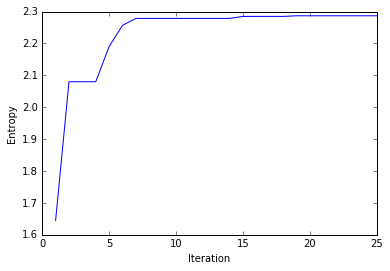

In [8]:
%matplotlib inline

entropy = []

for i in range(RUNS):
    count = {}
    for g, sig in group:
        _s = ','.join(map(str, sig[:(i + 1)]))
        count[_s] = count.get(_s, 0) + 1
    entropy.append(compute_entropy(count.values()))

plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.plot(range(1, RUNS + 1), entropy)
2**entropy[-1]

In [6]:
cost = get_cost(rdd, centroids)

In [7]:
log2 = np.log2
log2(np.max(cost)), log2(np.min(cost)), log2(np.mean(cost))

(33.825490212333918, 33.757533252505837, 33.779023610859163)